Романова Карина

In [12]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

In [13]:
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

In [14]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


In [15]:
def groups_splitter(df, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

In [5]:
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

Метрики:
   - is_viewed - айтем товара просмотрен
   - products_viewed_cnt - количество уникальных просмотренных айтемов
   - price_sum - суммарная цена товаров
   - is_cart_added - товар добавлен в корзину
   - is_purchased - товар куплен
   - cart_added_cnt - количество товаров, добавленных в корзину
   - purchased_cnt - количество купленных товаров

Попробуем удалить выбросы по стандартному отклонению и по 99 перцентилю:

In [22]:
# посчитаем параметры и вычислим "край" метрики для подхода "3 стандартных отклонения"

print(f" metric mean: {shop_metrics_new['cart_added_cnt'].mean()}, \
         metric std: {shop_metrics_new['cart_added_cnt'].std()}, \
         metric edge: {(shop_metrics_new['cart_added_cnt'].mean() + 3 * shop_metrics_new['purchased_cnt'].std())}")

 metric mean: 0.13679607767356788,          metric std: 0.6345408834915941,          metric edge: 1.1705709259834534


In [23]:
np.percentile(shop_metrics_new['cart_added_cnt'], 99)

2.0

In [24]:
shop_metrics_new[shop_metrics_new['cart_added_cnt'] > 1].count()

user_id                3900
group                  3900
is_viewed              3900
products_viewed_cnt    3900
price_sum              3900
is_cart_added          3900
is_purchased           3900
cart_added_cnt         3900
purchased_cnt          3900
dtype: int64

# 1. Ранговая трансформация

In [84]:
shop_metrics_new[shop_metrics_new.group == 'A'].cart_added_cnt.mean(), shop_metrics_new[shop_metrics_new.group == 'B'].cart_added_cnt.mean()

(0.1350419058398685, 0.1385521582733813)

In [85]:
(shop_metrics_new[shop_metrics_new.group == 'B'].cart_added_cnt.mean() - shop_metrics_new[shop_metrics_new.group == 'A'].cart_added_cnt.mean())/shop_metrics_new[shop_metrics_new.group == 'A'].cart_added_cnt.mean() 

0.02599380104776681

In [86]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()
    return df

In [87]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'], 
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')

In [88]:
ranked

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,100038.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,100038.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,100038.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,0.0,100038.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,0.0,100038.5
...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0.0,100038.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0.0,100038.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0.0,100038.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0.0,100038.5


In [28]:
ranked[ranked['cart_added_cnt'] > 0]

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,rank
13,1515915625353706476,A,1,12,522.75,0.0,0.0,2,0,219885.0
33,1515915625355805313,A,1,4,1336.40,0.0,0.0,1,0,209349.0
36,1515915625356129712,A,1,4,144.42,0.0,0.0,1,0,209349.0
108,1515915625367976920,A,1,4,144.83,0.0,0.0,1,1,209349.0
113,1515915625368720412,A,1,2,425.56,0.0,0.0,1,0,209349.0
...,...,...,...,...,...,...,...,...,...,...
222375,1515915625611002957,B,1,1,490.54,0.0,0.0,1,0,209349.0
222403,1515915625611007170,B,1,1,839.75,0.0,0.0,1,0,209349.0
222424,1515915625611010717,B,1,3,1493.89,0.0,0.0,2,0,219885.0
222440,1515915625611013140,B,1,2,642.29,0.0,0.0,2,0,219885.0


In [29]:
print(ranked[ranked.group == 'A']['rank'].mean(),
      ranked[ranked.group == 'B']['rank'].mean(), 
      ((ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) / 
       ranked[ranked.group == 'A']['rank'].mean()*100))

111170.45633348604 111351.6421897482 0.16298022175842064


In [30]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

Ttest_indResult(statistic=-1.2743727811526857, pvalue=0.20253266477504916)

In [31]:
stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'], 
                   shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

MannwhitneyuResult(statistic=6179368188.5, pvalue=0.2025319893087626)

Различие между группами мало и t-test не нашел разницу, при этом t-test на ранговой метрике показал почти одинаковый результат с mwhithney на обычной метрике

Для сравнения t-test на той же метрике, но без ранговой трансформации:

In [150]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'], 
                shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

Ttest_indResult(statistic=-1.3047727178459143, pvalue=0.1919716009958315)

Cредние тоже практически идентичны, но разница между группами в процентах больше, однако сам t-test на обычной метрике разницу тоже не нашел

In [40]:
print(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'].mean(),
      shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'].mean(),
     ((shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'].mean() - shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'].mean())/shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'].mean()) * 100)

0.1350419058398685 0.1385521582733813 2.5993801047766807


# 2. CUPED

In [59]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()


Возьмем исторические значения из датафрейма old

In [60]:
shop_metrics_old.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0,0.0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0,0.0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0,0.0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0,0.0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0,0.0


In [61]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')

In [62]:
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

In [63]:
shop_metrics_all

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,cart_added_cnt_covariate
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0.0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0.0,0
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0.0,0
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0.0,0
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0.0,0


In [64]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

In [65]:
shop_metrics_all_cuped.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0.0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0.0,0,0.132761


Проверим, как на измененной метрике покажет себя t-test:

In [66]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'], 
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

Ttest_indResult(statistic=-1.3855896128448428, pvalue=0.1658736404876475)

Сравним средние в измененной метрике и дисперсии:

In [49]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].mean()}')

метрика_cuped A: 0.13638231572657297,         метрика_cuped B: 0.13721028984714181
метрика без cuped A: 0.1350419058398685,         метрика без cuped B: 0.1385521582733813


In [50]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt"].var()}')

метрика_cuped A: 0.01823518359964533,         метрика_cuped B: 0.021495363455396536
метрика без cuped A: 0.3805867322090304,         метрика без cuped B: 0.4247189893567569


Супер, дисперсии понизились, значит CUPED сработал, средние не поменялись это тоже супер иначе выглядело бы странно

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]

 power: 100.0% , correctness: 98.0%


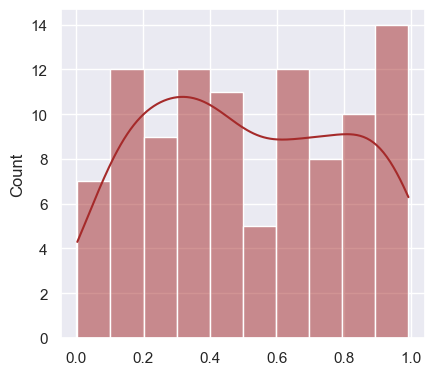

In [63]:
# мощность и корректность для CUPED

correctness = []
power = []

for i in tqdm(range(100)):
    
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    
    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']
    
    vec_b_effect = vec_b * 1.05
    
    
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)
    
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

In [51]:
shop_metrics_new['cart_added_cnt_ln'] = np.log(shop_metrics_new['cart_added_cnt'] + 1)

In [52]:
shop_metrics_old['cart_added_cnt_ln'] = np.log(shop_metrics_old['cart_added_cnt'] + 1)

In [53]:
shop['cart_added_cnt_ln'] = np.log(shop_metrics_old['cart_added_cnt_ln'] + 1)

In [55]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt_ln']], on=['user_id'], how='left')
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'cart_added_cnt_ln_x': 'cart_added_cnt_ln', 'cart_added_cnt_ln_y': 'cart_added_cnt_ln_covariate'})
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt_ln'])
print(stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_ln_cuped'], 
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_ln_cuped']))
print('---------------------------')
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln"].mean()}')
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["cart_added_cnt_ln"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["cart_added_cnt_ln"].var()}')
# мощность и корректность для CUPED


Ttest_indResult(statistic=-2.0493551017037106, pvalue=0.040428574068197394)
---------------------------
метрика_cuped A: 0.08034157852348374,         метрика_cuped B: 0.08072086382541542
метрика без cuped A: 0.07974289062640032,         метрика без cuped B: 0.08132020317245879
метрика_cuped A: 0.002055014378642917,         метрика_cuped B: 0.0017558187333519078
метрика без cuped A: 0.06466232955752058,         метрика без cuped B: 0.06628259108478471


 После применения логарифмирования получили интересные результаты, что p_val меньше 0.05 и это довольно интересно, получается после логарифмирования получили более чувствительную метрику - дисперсия стала меньше и после cuped тоже удалось ее понижить

Еще есть интересное наблюдение: применение cuped к обычной метрике сильно уменьшало дисперсию, в то время как к логарифмированной метрике cuped показал не такое большое уменьшение дисперсии

In [68]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_ln'], 
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_ln'])

Ttest_indResult(statistic=-1.4539361335316499, pvalue=0.14596542412011715)

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]

 power: 92.0% , correctness: 97.0%


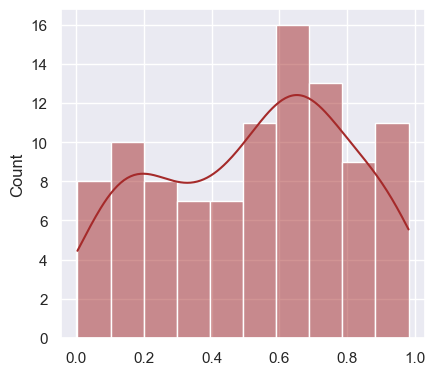

In [69]:
correctness = []
power = []

for i in tqdm(range(100)):
    
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt_ln']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_ln_x': 'cart_added_cnt_ln', 'cart_added_cnt_ln_y': 'cart_added_cnt_ln_covariate'})
    
    cuped_df = cuped_transform(all_df, ['cart_added_cnt_ln'])
    
    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_ln_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_ln_cuped']
    
    vec_b_effect = vec_b * 1.05
    
    
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)
    
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')


In [72]:
shop_metrics_all_cuped

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0.0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0.0,0,0.132761
...,...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0.0,0,0.132761
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0.0,0,0.132761
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0.0,0,0.132761
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0.0,0,0.132761


In [73]:
ranked = rank_transformation(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'], 
                             shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'], 'cart_added_cnt_cuped')

In [76]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])


Ttest_indResult(statistic=-1.4459909525623789, pvalue=0.14818114788143424)

In [89]:
print('на метрике без cuped')
print(ranked[ranked.group == 'A']['rank'].mean(),
      ranked[ranked.group == 'B']['rank'].mean(), 
      ((ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) / 
       ranked[ranked.group == 'A']['rank'].mean()*100))

на метрике без cuped
111170.45633348604 111351.6421897482 0.16298022175842064


In [92]:
print('на метрике без cuped')
print(ranked[ranked.group == 'A']['rank'].var(),
      ranked[ranked.group == 'B']['rank'].var())

на метрике без cuped
1116108735.2907896 1132936846.743577


In [83]:
print(f'метрика_cuped A: {ranked[ranked.group == "A"]["rank"].mean()}, \
        метрика_cuped B: {ranked[ranked.group == "B"]["rank"].mean()}')


метрика_cuped A: 111157.3299691882,         метрика_cuped B: 111364.78283723022


In [82]:
print(f'метрика_cuped A: {ranked[ranked.group == "A"]["rank"].var()}, \
        метрика_cuped B: {ranked[ranked.group == "B"]["rank"].var()}')


метрика_cuped A: 1138307738.193268,         метрика_cuped B: 1151768826.5589178


Тут в целом после cuped и рангового преобразования дисперсия особо и не поменялась

In [78]:
stats.mannwhitneyu(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'], 
                   shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

MannwhitneyuResult(statistic=6177906948.5, pvalue=0.1481807511975509)

# 3. Реализовать разбивку на бакеты, оценить t-критерием и сравнить с результатом без бакетирования:

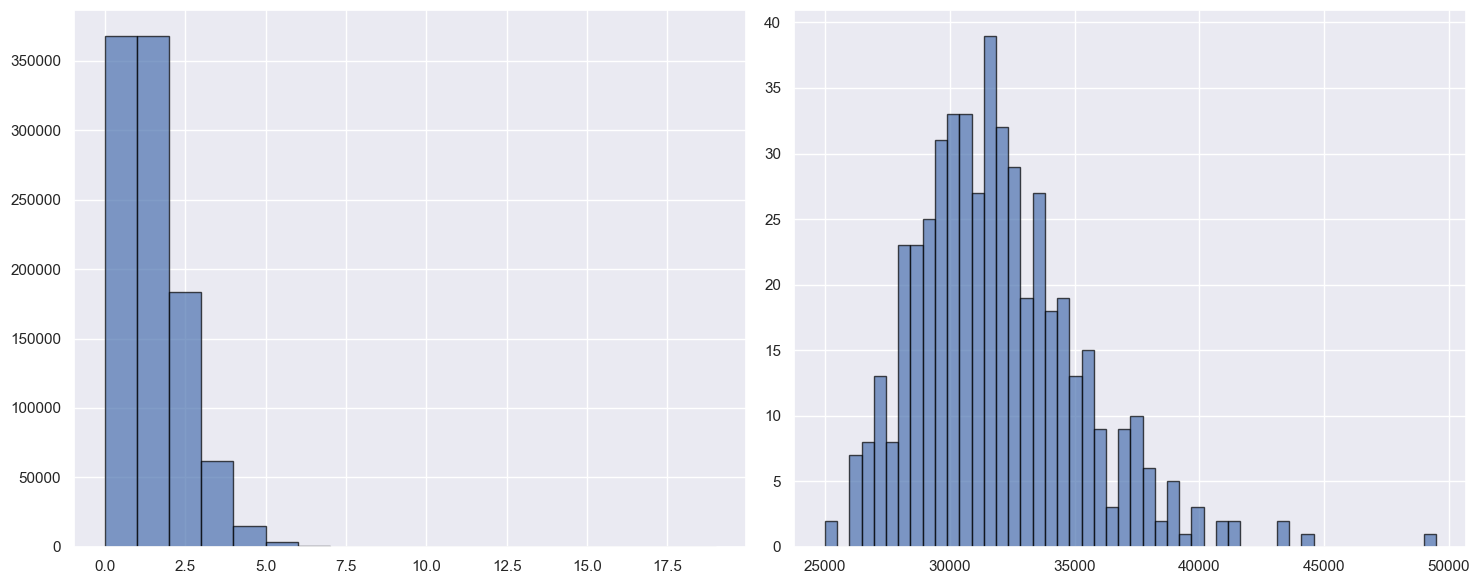

In [102]:
# параметры
mu, sigma = 0.1, 2 # среднее значение и стандартное отклонение
sample_size = 10000000  # размер выборки
data = np.random.lognormal(mu, sigma, sample_size)
num_buckets = 500
# группировка пользователей по бакетам и подсчет суммы покупок в каждом бакете
bucket_sums = []
for i in range(num_buckets):
    bucket_sum = np.sum(data[i * users_per_bucket: (i + 1) * users_per_bucket])
    bucket_sums.append(bucket_sum)

# визуализация
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(purchases, bins=range(20), edgecolor='black', alpha=0.7)


plt.subplot(1, 2, 2)
plt.hist(bucket_sums, bins=50, edgecolor='black', alpha=0.7)

plt.tight_layout()
plt.show()

In [136]:
df_list = pd.DataFrame(data)

In [138]:
df_list['user_id'] = range(len(df_list))
df_list['group'] = range(len(df_list))
df_list['group'].loc[0:len(df_list)/2] = 'A'
df_list['group'].loc[len(df_list)/2:] = 'B'

In [149]:
group_A = df_list[df_list['group'] == 'A']
group_B = df_list[df_list['group'] == 'B']

# Применение функции генерации бакетов к каждой группе
group_A['bucket'] = group_A['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'salt_A').encode()).hexdigest(), 16) % 250
)
group_B['bucket'] = group_B['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'salt_B').encode()).hexdigest(), 16) % 250
)

# Объединение групп обратно в один DataFrame
w = pd.concat([group_A, group_B])

/var/folders/rb/xr511ym54773mfmyy2h4lmfr0000gn/T/ipykernel_71894/477657105.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_A['bucket'] = group_A['user_id'].apply(
/var/folders/rb/xr511ym54773mfmyy2h4lmfr0000gn/T/ipykernel_71894/477657105.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_B['bucket'] = group_B['user_id'].apply(


In [154]:
groupedw = w.groupby(['group', 'bucket']).agg({0:'mean'}).reset_index()

In [152]:
stats.ttest_ind(group_A[0], group_B[0])

Ttest_indResult(statistic=0.0385607972170492, pvalue=0.9692405590890094)

In [156]:
stats.ttest_ind(groupedw[groupedw .group == 'A'][0], 
                groupedw[groupedw .group == 'B'][0])

Ttest_indResult(statistic=0.048276703567526294, pvalue=0.9615150753419535)

На рандомных данных не особо отличаются результаты

In [128]:
group_A = shop_metrics_new[shop_metrics_new['group'] == 'A']
group_B = shop_metrics_new[shop_metrics_new['group'] == 'B']

# Применение функции генерации бакетов к каждой группе
group_A['bucket'] = group_A['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'salt_A').encode()).hexdigest(), 16) % 250
)
group_B['bucket'] = group_B['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'salt_B').encode()).hexdigest(), 16) % 250
)

# Объединение групп обратно в один DataFrame
show_metrcs_new_bucket = pd.concat([group_A, group_B])

/var/folders/rb/xr511ym54773mfmyy2h4lmfr0000gn/T/ipykernel_71894/1177430899.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_A['bucket'] = group_A['user_id'].apply(
/var/folders/rb/xr511ym54773mfmyy2h4lmfr0000gn/T/ipykernel_71894/1177430899.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_B['bucket'] = group_B['user_id'].apply(


In [129]:
show_metrcs_new_bucket

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,bucket
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,131
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,216
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,0.0,6
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0.0,180
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0.0,191
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0.0,174
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0.0,181


<AxesSubplot: >

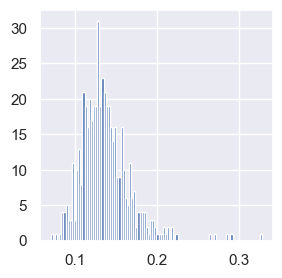

In [130]:
grouped= show_metrcs_new_bucket.groupby(['group', 'bucket']).agg({'cart_added_cnt':'mean'}).reset_index()
grouped['cart_added_cnt'].hist(bins=100, figsize=(3,3))

In [134]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'], 
                shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])

Ttest_indResult(statistic=-1.3047727178459143, pvalue=0.1919716009958315)

In [135]:
stats.ttest_ind(grouped[grouped.group == 'A']['cart_added_cnt'], grouped[grouped.group == 'B']['cart_added_cnt'])

Ttest_indResult(statistic=-1.335495582158915, pvalue=0.18232426384983083)

Получили довольно похожие результаты, но после объединения в бакеты распределение становится большим похоже на нормальное и мы в целом можем убрать такую ситуацию, что в выборках будут зависимые данные

#  4. Постстратификация

In [177]:
shop_w_features = pd.merge(shop_metrics_old, shop_users_info, on=['user_id'], how='left')

In [184]:
shop_w_features 

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_ln,user_age,user_sex,age_group
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0,0.0,55,f,46-60
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0,0.0,58,m,46-60
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0,0.0,23,f,18-24
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0,0.0,33,m,25-45
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0,0.0,26,f,25-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
406858,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0.0,76,m,76+
406859,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0.0,34,m,25-45
406860,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0.0,62,m,61-75
406861,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0.0,48,f,46-60


In [178]:
conditions = [
    (shop_w_features['user_age'] >= 18) & (shop_w_features['user_age'] <= 24),
    (shop_w_features['user_age'] >= 25) & (shop_w_features['user_age'] <= 45),
    (shop_w_features['user_age'] >= 46) & (shop_w_features['user_age'] <= 60),
    (shop_w_features['user_age'] >= 61) & (shop_w_features['user_age'] <= 75),
    (shop_w_features['user_age'] >= 76)
]
choices = ['18-24', '25-45', '46-60', '61-75', '76+']
shop_w_features['age_group'] = np.select(conditions, choices)

# Расчет весов страт (пол + возраст)
N = shop_w_features['user_id'].nunique()
strats = shop_w_features.groupby(['user_sex', 'age_group']).size().reset_index(name='count')
strats['weight'] = strats['count'] / N

# Расчет взвешенных средних и стандартных отклонений для групп A и B
def weighted_stats(group):
    group_data = shop_w_features[shop_w_features['group'] == group]
    stats = group_data.merge(strats, on=['user_sex', 'age_group'])
    weighted_mean = sum(stats['cart_added_cnt'] * stats['weight'])
    weighted_std = np.sqrt(sum((stats['cart_added_cnt'].std() ** 2) * stats['weight'] / N))
    return weighted_mean, weighted_std, len(group_data)

mean_a, std_a, n_a = weighted_stats('A')
mean_b, std_b, n_b = weighted_stats('B')

# Вывод результатов и t-тест
print(f'Group A: mean = {mean_a}, std = {std_a}, n = {n_a}')
print(f'Group B: mean = {mean_b}, std = {std_b}, n = {n_b}')

# Выполнение t-теста
stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)

Group A: mean = 2911.4223706747575, std = 0.14020671361557277, n = 203336
Group B: mean = 2925.9647596364935, std = 0.14567425553734142, n = 203527


Ttest_indResult(statistic=-32440.777265730958, pvalue=0.0)

In [179]:
mean_a, mean_b, std_a, std_b, 

(2911.4223706747575,
 2925.9647596364935,
 0.14020671361557277,
 0.14567425553734142)

In [180]:
print(f'effect: {(mean_b - mean_a)/mean_a*100}, std_a: {std_a}, std_b: {std_b}')

effect: 0.49949430588340055, std_a: 0.14020671361557277, std_b: 0.14567425553734142


In [181]:
strats

,user_sex,age_group,count,weight
0,f,18-24,16952,0.041665
1,f,25-45,50979,0.125298
2,f,46-60,36447,0.089581
3,f,61-75,36185,0.088937
4,f,76+,22207,0.054581
5,m,18-24,25706,0.063181
6,m,25-45,76922,0.189061
7,m,46-60,54604,0.134207
8,m,61-75,54250,0.133337
9,m,76+,32611,0.080152


In [183]:
n_iterations = 100 
results = [] 
correctness = [] 
power = []

for _ in tqdm(range(n_iterations)):
    new_groups = groups_splitter(shop_w_features.copy(), user_salt=salt_generator())
    merged_df = pd.merge(shop_w_features, new_groups, how='left', on='user_id')

    N = merged_df['user_id'].nunique()
    strats = merged_df.groupby(['user_sex', 'age_group']).size().reset_index(name='count')
    strats['weight'] = strats['count'] / N

    def weighted_stats(group):
        group_data = merged_df[merged_df['group_y'] == group]
        stats = group_data.merge(strats, on=['user_sex', 'age_group'])
        weighted_mean = sum(stats['cart_added_cnt'] * stats['weight'])
        weighted_std = np.sqrt(sum((stats['cart_added_cnt'].std() ** 2) * stats['weight'] / N))
        return weighted_mean, weighted_std, len(group_data)

    mean_a, std_a, n_a = weighted_stats('A')
    mean_b, std_b, n_b = weighted_stats('B')

    t_statistic, p_value_cor = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)
    correctness.append(p_value_cor)

    mean_b_effect = mean_b * 1.05
    t_statistic, p_value_power = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b_effect, std_b, n_b)
    power.append(p_value_power)

    results.append([mean_a, std_a, n_a, mean_b, std_b, n_b, t_statistic, p_value_cor])
power = (len([p for p in power if p < 0.05]) / n_iterations) * 100
correctness = (len([p for p in correctness if p < 0.05]) / n_iterations) * 100


mean_results = np.mean(results, axis=0)
std_results = np.std(results, axis=0)

print(f'Средние результаты: {mean_results}')
print(f'Стандартные отклонения результатов: {std_results}')
print(f'Мощность: {power}%, Корректность: {correctness}%')

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]

Средние результаты: [ 2.91530577e+03  1.42814770e-01  2.03423620e+05  2.92208136e+03
  1.42917702e-01  2.03439380e+05 -3.41043656e+05  0.00000000e+00]
Стандартные отклонения результатов: [2.37357351e+01 5.31700273e-03 3.08821851e+02 2.37357351e+01
 5.34394764e-03 3.08821851e+02 1.08544420e+05 0.00000000e+00]
Мощность: 100.0%, Корректность: 100.0%
